In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Configurable parameters for pure pursuit
+ How fast do you want the robot to move? It is fixed at $v_{max}$ in this exercise
+ When can we declare the goal has been reached?
+ What is the lookahead distance? Determines the next position on the reference path that we want the vehicle to catch up to

In [54]:
vmax = 0.75
goal_threshold = 0.05
lookahead = 3.0

In [55]:
#You know what to do!
def simulate_unicycle(pose, v,w, dt=0.1):
    x, y, t = pose
    return x + v*np.cos(t)*dt, y + v*np.sin(t)*dt, t+w*dt

In [56]:
x_ref=[]
y_ref=[]
class PurePursuitTracker(object):
    global x_ref, y_ref
    def __init__(self, x, y, v, lookahead = 3.0):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        v and lookahead are floats
        """
        self.length = len(x)
        self.ref_idx = 0 #index on the path that tracker is to track
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.w = v, 0

    def update(self, xc, yc, theta):
        """
        Input: xc, yc, theta - current pose of the robot
        Update v, w based on current pose
        Returns True if trajectory is over.
        """
        
        #Calculate ref_x, ref_y using current ref_idx
        #Check if we reached the end of path, then return TRUE
        #Two conditions must satisfy
        #1. ref_idx exceeds length of traj
        #2. ref_x, ref_y must be within goal_threshold
        # Write your code to check end condition
        ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx]
        x_ref.append(ref_x)   # Used for animation
        y_ref.append(ref_y)   # Used for animation
        goal_x, goal_y = self.x[-1], self.y[-1]
        if (self.ref_idx > self.length) or (np.linalg.norm([ref_x-goal_x, ref_y-goal_y])) < goal_threshold:
              return True

        #End of path has not been reached
        #update ref_idx using np.hypot([ref_x-xc, ref_y-yc]) < lookahead
        if np.hypot(ref_x-xc, ref_y-yc) < lookahead:
          # print(self.ref_idx)
          self.ref_idx = self.ref_idx + 1

        #Find the anchor point
        # this is the line we drew between (0, 0) and (x, y)
        anchor = np.asarray([ref_x - xc, ref_y - yc])
        #Remember right now this is drawn from current robot pose
        #we have to rotate the anchor to (0, 0, pi/2)
        #code is given below for this
        theta = np.pi/2 - theta
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])   # Rotational matrix
        anchor = np.dot(rot, anchor)
        
        L = np.sqrt((anchor[0] ** 2 + anchor[1] **2)) # dist to reference path
        X = anchor[0] #cross-track error
        #from the derivation in not yc, thetaes, plug in the formula for omega
        self.w = -1*(2 * self.v * X)/(L**2)
        
        return False

## Visualize given trajectory

<Figure size 432x288 with 0 Axes>

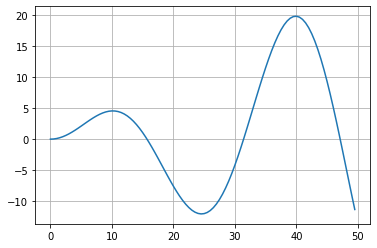

<Figure size 432x288 with 0 Axes>

In [57]:
x = np.arange(0, 50, 0.5)
y = [np.sin(idx / 5.0) * idx / 2.0 for idx in x]
#write code here
plt.plot(x, y)
plt.grid()
plt.figure()


## Run the tracker simulation

1. Instantiate the tracker class
2. Initialize some starting pose
3. Simulate robot motion 1 step at a time - get $v$, $\omega$ from tracker, predict new pose using $v$, $\omega$, current pose in simulate_unicycle()
4. Stop simulation if tracker declares that end-of-path is reached
5. Record all parameters

In [58]:
#write code to instantiate the tracker class
tracker = PurePursuitTracker(x, y, vmax) 
pose = -1, 0, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting
traj =[]
while True:
    #write the usual code to obtain successive poses
    pose = simulate_unicycle(pose, tracker.v, tracker.w)
    xa, ya, ta = pose
    if tracker.update(xa, ya, ta):
        print("ARRIVED!!")    
        break
    traj.append([xa, ya, ta, tracker.w, tracker.ref_idx])

ARRIVED!!


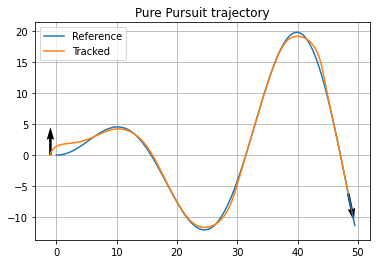

In [59]:
xs,ys,ts,ws,ids = zip(*traj)
plt.figure()
plt.plot(x,y,label='Reference')
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
plt.plot(xs,ys,label='Tracked')
x0,y0,t0 = pose
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
plt.title('Pure Pursuit trajectory')
plt.legend()
plt.grid()

# Visualize curvature

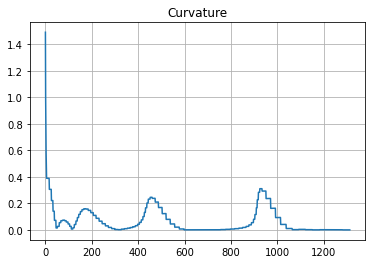

In [60]:
plt.figure()
plt.title('Curvature')
plt.plot(np.abs(ws))
plt.grid()


## Animate

Make a video to plot the current pose of the robot and reference pose it is trying to track. You can use funcAnimation in matplotlib

The first line sets up the figure and its axis, and the second line fixes the axis limits. Setting the limits in advance stops any rescaling of the limits that may make the animation jumpy and unusable.


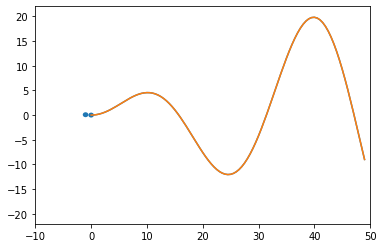

In [61]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from IPython.display import HTML 
plt.rcParams["animation.html"] = "jshtml"
rc('animation', embed_limit=4096)

fig, ax = plt.subplots()
ax.set_xlim(-10, 50)
ax.set_ylim(-22,22)
line = ax.plot(0,0)[0]
tracked = ax.plot(0,0)[0]
ball = plt.Circle((x0, y0), 0.5)
ball_tracked = plt.Circle((x0, y0), 0.5)
ax.add_patch(ball)
ax.add_patch(ball_tracked)
x_data=[]
y_data=[]

x_track=[]
y_track=[]

def init():
    ax.set_xlim(-10, 50)
    ax.set_ylim(-22,22)
    line.set_data(x_data, y_data)
    line.set_data(x_track, y_track)
    ball.set_center((xs[0], ys[0]))
    ball_tracked.set_center((x_ref[0], y_ref[0]))
    return line, ball, ball_tracked

def animate(i):
    # Plot bot trajectory
    x_data.append(xs[i])
    y_data.append(ys[i])
    ball.set_center((xs[i], ys[i]))
    line.set_xdata(x_data)
    line.set_ydata(y_data)

    # Plot reference trajectory the bot is tracking
    x_track.append(x_ref[i])
    y_track.append(y_ref[i])
    ball_tracked.set_center((x_ref[i], y_ref[i]))
    tracked.set_xdata(x_track)
    tracked.set_ydata(y_track)

animation = FuncAnimation(fig, animate, frames=np.arange(0,1314),interval=15, init_func=init)
# animation
HTML(animation.to_html5_video())

## Effect of noise in simulations

What happens if you add a bit of Gaussian noise to the simulate_unicycle() output? Is the tracker still robust?

The noise signifies that $v$, $\omega$ commands did not get realized exactly
